1. Create a straight line dataset using the linear regression formula (`weight * X + bias`).
  * Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total. 
  * Split the data into 80% training, 20% testing.
  * Plot the training and testing data so it becomes visual.

In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt 
import warnings

warnings.simplefilter('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
SEED = 42 

In [3]:
# 1
weight = 0.3
bias = 0.9
X = torch.arange(0, 100)
y = weight*X + bias
train_split = int(0.8 * len(X))
X_train, y_train, X_test, y_test = X[:train_split], y[:train_split], X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

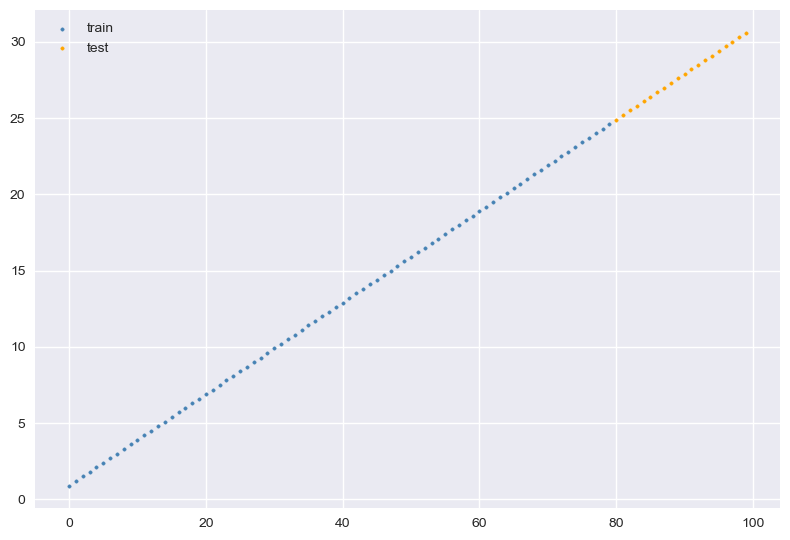

In [4]:
plt.style.use('seaborn')
plt.scatter(X_train, y_train, s=6, color="steelblue", label="train")
plt.scatter(X_test, y_test, s=6, color="orange", label="test")
plt.legend()
plt.tight_layout()
plt.show();

2. Build a PyTorch model by subclassing `nn.Module`. 
  * Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`. 
  * Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1. 
  * Once you've constructed the model, make an instance of it and check its `state_dict()`.
  * **Note:** If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.

In [5]:
# 2
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True) 
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True) 

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.weights * x + self.bias


In [6]:
# class LinearRegressionModel(nn.Module): 
#     def __init__(self):
#         super().__init__() 
#         self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True) 
#         self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True) 

#     def forward(self, x: torch.Tensor) -> torch.Tensor: 
#         return self.weights * x + self.bias

In [7]:
torch.manual_seed(SEED)
model_linear = LinearRegression()
model_linear.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_linear.to(device)
next(model_linear.parameters()).to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively. 
  * Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
  * Write a training loop to perform the appropriate training steps for 300 epochs.
  * The training loop should test the model on the test dataset every 20 epochs.

In [9]:
# 3
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_linear.parameters(), lr=0.01)

In [10]:
epochs = 300
loss_train_values = []
loss_test_values = []

for epoch in range(epochs):
    # train
    model_linear.train()
    y_pred_train = model_linear(X_train)
    loss_train = loss_fn(y_pred_train, y_train)
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    loss_train_values.append(loss_train.detach().numpy())

    # evaluate
    model_linear.eval()
    with torch.inference_mode():
        y_pred_test = model_linear(X_test)
        loss_test = loss_fn(y_pred_test, y_test.type(torch.float))
        loss_test_values.append(loss_test.detach().numpy())
        if epoch % 20 == 0:
            print(f" Epoch: {epoch} | MAE Train loss: {loss_train} | MAE Test loss: {loss_test}")    

        # if epoch % 10 == 0:
        #         epoch_count.append(epoch)
        #         train_loss_values.append(loss.detach().numpy())
        #         test_loss_values.append(test_loss.detach().numpy())
        #         print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

 Epoch: 0 | MAE Train loss: 0.8903464078903198 | MAE Test loss: 27.6757755279541
 Epoch: 20 | MAE Train loss: 4.886396884918213 | MAE Test loss: 23.13906478881836
 Epoch: 40 | MAE Train loss: 6.025297164916992 | MAE Test loss: 20.664871215820312
 Epoch: 60 | MAE Train loss: 6.8605499267578125 | MAE Test loss: 18.863656997680664
 Epoch: 80 | MAE Train loss: 7.459794521331787 | MAE Test loss: 17.511171340942383
 Epoch: 100 | MAE Train loss: 8.059048652648926 | MAE Test loss: 16.15866470336914
 Epoch: 120 | MAE Train loss: 8.599006652832031 | MAE Test loss: 15.008291244506836
 Epoch: 140 | MAE Train loss: 8.901609420776367 | MAE Test loss: 14.329591751098633
 Epoch: 160 | MAE Train loss: 9.204214096069336 | MAE Test loss: 13.650891304016113
 Epoch: 180 | MAE Train loss: 9.506816864013672 | MAE Test loss: 12.972187995910645
 Epoch: 200 | MAE Train loss: 9.809420585632324 | MAE Test loss: 12.293486595153809
 Epoch: 220 | MAE Train loss: 10.112024307250977 | MAE Test loss: 11.614785194396973

4. Make predictions with the trained model on the test data.
  * Visualize these predictions against the original training and testing data (**note:** you may need to make sure the predictions are *not* on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

3

5. Save your trained model's `state_dict()` to file.
  * Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
  * Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

3